In [1]:
import sys
sys.path.append("/OLD-DATA-STOR/HESSO_Internship_2023/Dariusz")
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import random
import csv
from pathlib import Path
from IPython.display import clear_output

from Python.utils.utils import extract_segmentation_slices

In [2]:
SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud"
MHA_SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud/correct_mha_filtered"
NRRD_SOURCE_FOLDERPATH = "/OLD-DATA-STOR/segmentation ovud/correct_seg_nrrd_filtered"

image: Della_Santa_Beba_Silky_Terrier.mha
indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 86 87 88 89 90 91 92 93 94 95 96 97 98]
k: [45, 89, 31, 95]


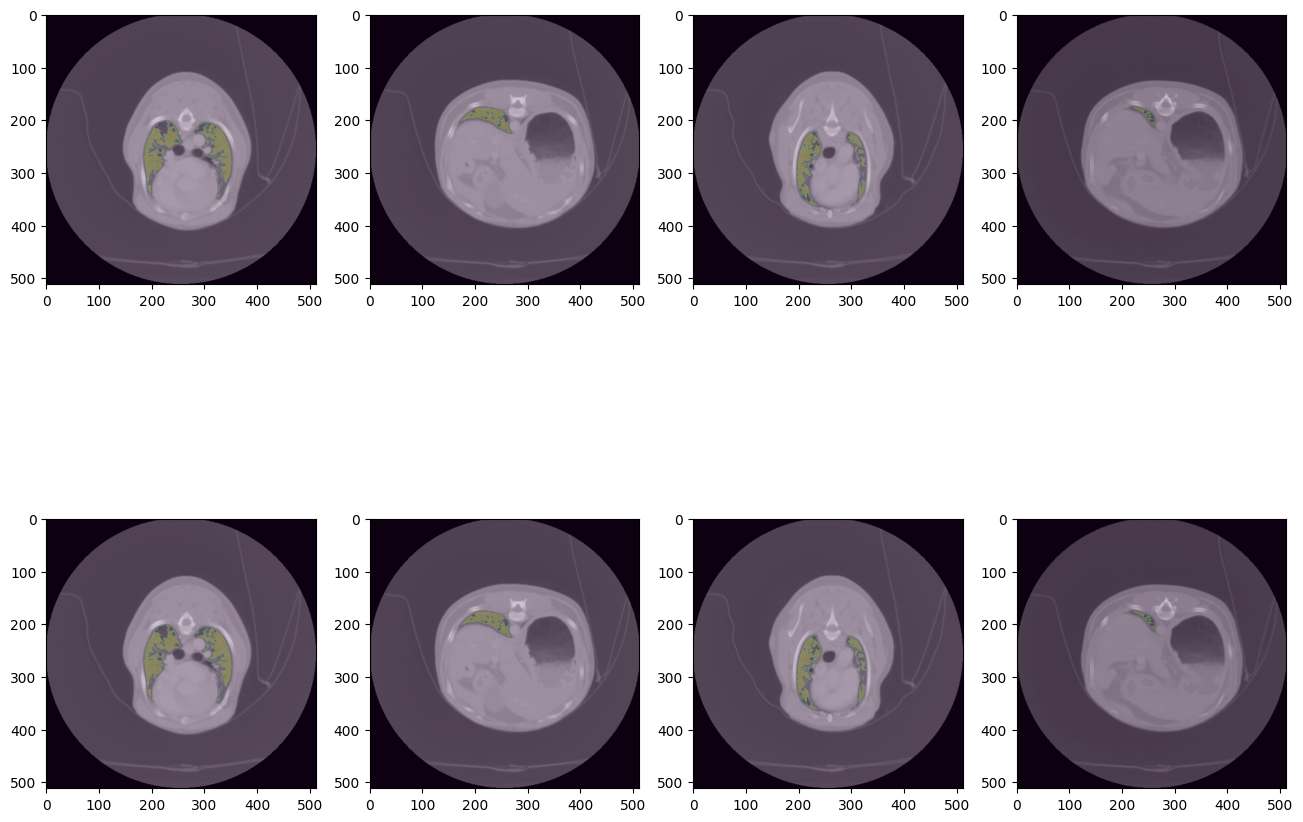

Reset Image spacing: (0.41500000000000004, 0.41500000000000004, 1.4999999999999996)
Reset Image direction: (-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Reset Image origin: (95.625, -102.50000000000007, -917.4999999999997)
Original segmentation spacing: (0.41500000000000004, 0.41500000000000004, 1.4999999999999996)
Original segmentation direction: (-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Original segmentation origin: (95.625, -102.50000000000007, -917.4999999999997)


KeyboardInterrupt: Interrupted by user

In [7]:
images = sorted(os.listdir(MHA_SOURCE_FOLDERPATH))
segmentations = sorted(os.listdir(NRRD_SOURCE_FOLDERPATH))

with open('data_validation.csv', 'w') as f:
    writer = csv.writer(f, delimiter="#")
    writer.writerow("Index#Comment".strip('#').split('#'))
    # for i in range(1):
    for i in range(len(os.listdir(MHA_SOURCE_FOLDERPATH))):

        image = sitk.ReadImage(os.path.join(MHA_SOURCE_FOLDERPATH, images[i]))
        image_arr = sitk.GetArrayFromImage(image)
        seg = sitk.ReadImage(os.path.join(NRRD_SOURCE_FOLDERPATH, segmentations[i]))
        seg_arr = sitk.GetArrayFromImage(seg)

        indices = extract_segmentation_slices(seg_arr)

        # image_resampled = sitk.Resample(image, referenceImage=seg, interpolator=sitk.sitkBSpline)
        image_resampled = image
        image_resampled_arr = sitk.GetArrayFromImage(image_resampled)

        image_resampled_metadata_reset = sitk.GetImageFromArray(image_resampled_arr)
        image_resampled_metadata_reset.SetSpacing(seg.GetSpacing())
        image_resampled_metadata_reset.SetDirection(seg.GetDirection())
        image_resampled_metadata_reset.SetOrigin(seg.GetOrigin())

        image_resampled_metadata_reset_arr = sitk.GetArrayFromImage(image_resampled_metadata_reset)

        fig, axs = plt.subplots(2,4, figsize=(16,12))

        k = random.choices(indices, k=4)
        print(f"image: {images[i]}")
        print(f"indices: {indices}")
        print(f"k: {k}")

        # axs[0][0].imshow(image_arr[k[0]], cmap='gray')
        # axs[0][0].imshow(seg_arr[k[0]], alpha=0.2)

        # axs[0][1].imshow(image_arr[k[1]], cmap='gray')
        # axs[0][1].imshow(seg_arr[k[1]], alpha=0.2)

        # axs[0][2].imshow(image_arr[k[2]], cmap='gray')
        # axs[0][2].imshow(seg_arr[k[2]], alpha=0.2)

        # axs[0][3].imshow(image_arr[k[3]], cmap='gray')
        # axs[0][3].imshow(seg_arr[k[3]], alpha=0.2)


        # axs[1][0].imshow(image_arr[k[0]], cmap='gray')
        # # axs[1][0].imshow(seg_arr[k[0]], alpha=0.2)

        # axs[1][1].imshow(image_arr[k[1]], cmap='gray')
        # # axs[1][1].imshow(seg_arr[k[1]], alpha=0.2)

        # axs[1][2].imshow(image_arr[k[2]], cmap='gray')
        # # axs[1][2].imshow(seg_arr[k[2]], alpha=0.2)

        # axs[1][3].imshow(image_arr[k[3]], cmap='gray')
        # # axs[1][3].imshow(seg_arr[k[3]], alpha=0.2)

        # plt.show()

        axs[0][0].imshow(image_arr[k[0]], cmap='gray')
        axs[0][0].imshow(seg_arr[k[0]], alpha=0.2)

        axs[0][1].imshow(image_arr[k[1]], cmap='gray')
        axs[0][1].imshow(seg_arr[k[1]], alpha=0.2)

        axs[0][2].imshow(image_arr[k[2]], cmap='gray')
        axs[0][2].imshow(seg_arr[k[2]], alpha=0.2)

        axs[0][3].imshow(image_arr[k[3]], cmap='gray')
        axs[0][3].imshow(seg_arr[k[3]], alpha=0.2)


        axs[1][0].imshow(image_resampled_metadata_reset_arr[k[0]], cmap='gray')
        axs[1][0].imshow(seg_arr[k[0]], alpha=0.2)

        axs[1][1].imshow(image_resampled_metadata_reset_arr[k[1]], cmap='gray')
        axs[1][1].imshow(seg_arr[k[1]], alpha=0.2)

        axs[1][2].imshow(image_resampled_metadata_reset_arr[k[2]], cmap='gray')
        axs[1][2].imshow(seg_arr[k[2]], alpha=0.2)

        axs[1][3].imshow(image_resampled_metadata_reset_arr[k[3]], cmap='gray')
        axs[1][3].imshow(seg_arr[k[3]], alpha=0.2)

        plt.show()

        print(f"Reset Image spacing: {image_resampled_metadata_reset.GetSpacing()}")
        print(f"Reset Image direction: {image_resampled_metadata_reset.GetDirection()}")
        print(f"Reset Image origin: {image_resampled_metadata_reset.GetOrigin()}")

        print(f"Original segmentation spacing: {seg.GetSpacing()}")
        print(f"Original segmentation direction: {seg.GetDirection()}")
        print(f"Original segmentation origin: {seg.GetOrigin()}")

        row = ''
        row += str(i)+'#'
        # row += os.path.splitext(images[i])[0]+'#'

        uinput = input("Comment on the image:\n0 - OK\n1 - NOK")
        if uinput == "0":
            row += "OK"
        if uinput == "1":
            row += "CHECK"
        # elif uinput == "2":
        #     row += "LOW_SEG"
        # else:
        #     row += "USER_INPUT_ERROR"
        
        # autocomment="-"
        # if len(indices) < 15:
        #     autocomment = "Small amount of segmented slices."
        # row += autocomment

        columns = [c.strip() for c in row.strip('#').split('#')]

        writer.writerow(columns)
        
        row=''
        clear_output(wait=True)




### Co udało się zrobić:
1. Data mining:
- Ogólny opis całego dostępnego datasetu, zawierane klasy
- Odsortowanie niepotrzebnych plików
- Wyodrębnienie koniecznych metadanych opisujących segmentację
- Przygotowanie skryptów eksplorujących zbiór danych
- Przygotowanie statystyk: ilość danych oznaczonych, ilość danych nieoznaczonych, ilość wystąpień każdej z klas (chorób) na danych oznaczonych
- Zliczanie objętości różnych klas na pojedynczym zdjęciu w pikselach
2. Wizualizacja wyników
- Przygotowanie skryptu do automatycznej generacji wizualizacji dla zadanego przypadku, z możliwością dodania własnych oraz automatycznych komentarzy, zapisywanych do pliku CSV
- Finalne wizualne sprawdzenie kompatybilności obrazów z segmentacjami w oparciu o próbę losową
- Przygotowanie pliku z krótkimi komentarzami odnoszącymi się do wielkości oznaczonych obszarów na zdjęciach
### Co jest jeszcze do zrobienia:
- Zliczanie objętości w wokselach
- Po konsultacji - możliwość pogrupowania klas między sobą np "mass", "node" itp
- Opis dotychczasowych prac w Overleafie
- nnUNet - poczytać w kategoriach wykorzystania w oparciu o odpowiednio przygotowane dane
- skrypt do automatycznego odsiewu wadliwych danych, sprawdzający:
    * czy obraz zawiera jakąkolwiek segmentację
    * czy wszystkie zaznaczone segmentacje faktycznie występują (ilość unikatowych wartości pikseli w segmentacji w stosunku do ilości rodzajów segmentacji)
    * czy między zdjęciem a segmentacją zgadza się space origin, rotacja (?), offset(?)

[87, 87, 85, 85]


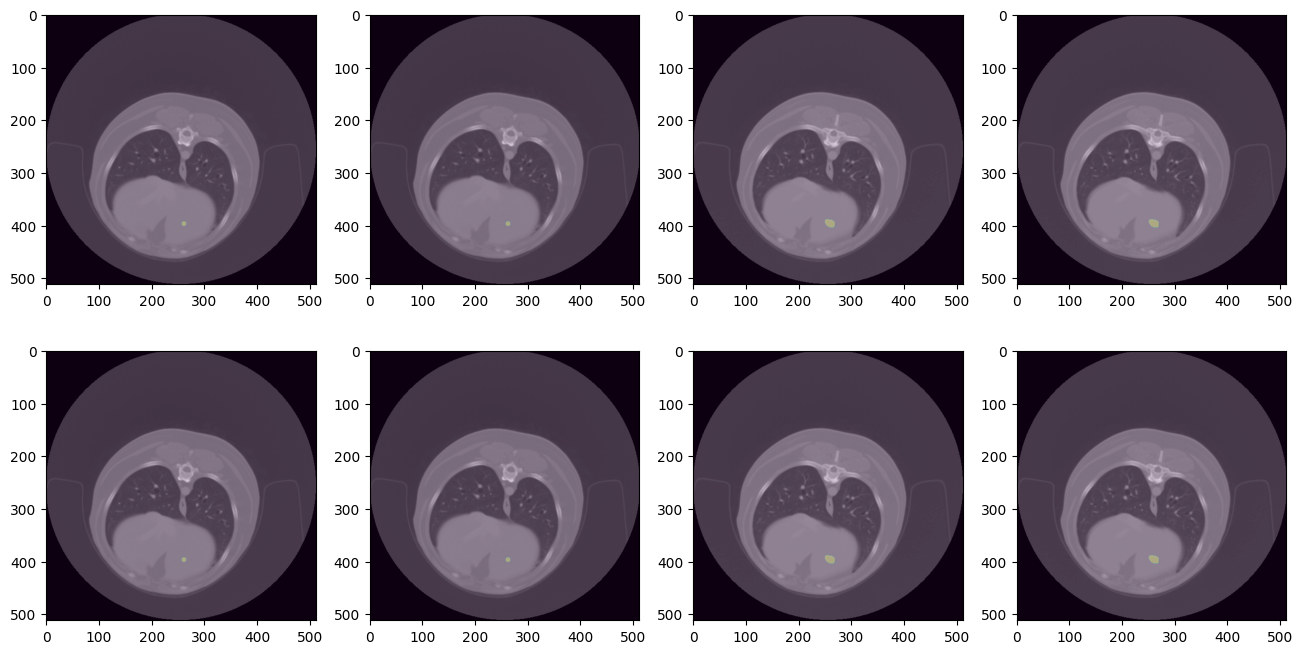

Reset Image spacing: (0.5079999999999999, 0.5079999999999999, 1.4999999999999996)
Reset Image direction: (-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Reset Image origin: (109.5898, -115.78119999999994, -767.9999999999998)
Original segmentation spacing: (0.5079999999999999, 0.5079999999999999, 1.4999999999999996)
Original segmentation direction: (-1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Original segmentation origin: (109.5898, -115.78119999999994, -767.9999999999998)


In [6]:
imgname = "Agostinis_Zoe_Lakeland_Terrier.mha"
segname = "Agostinis_Zoe_Lakeland_Terrier.seg.nrrd"

image = sitk.ReadImage(os.path.join(MHA_SOURCE_FOLDERPATH, imgname))
seg = sitk.ReadImage(os.path.join(NRRD_SOURCE_FOLDERPATH, segname))

image_arr = sitk.GetArrayFromImage(image)
seg_arr = sitk.GetArrayFromImage(seg)

# image_resampled = sitk.Resample(image, referenceImage=seg, interpolator=sitk.sitkBSpline)
image_resampled = image
image_resampled_arr = sitk.GetArrayFromImage(image_resampled)

image_resampled_metadata_reset = sitk.GetImageFromArray(image_resampled_arr)
image_resampled_metadata_reset.SetSpacing(seg.GetSpacing())
image_resampled_metadata_reset.SetDirection(seg.GetDirection())
image_resampled_metadata_reset.SetOrigin(seg.GetOrigin())

image_resampled_metadata_reset_arr = sitk.GetArrayFromImage(image_resampled_metadata_reset)

indices = extract_segmentation_slices(seg_arr)
# k = random.choices(indices, k=4)
k = [87, 87, 85, 85]
print(k)
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0][0].imshow(image_arr[k[0]], cmap='gray')
axs[0][0].imshow(seg_arr[k[0]], alpha=0.2)

axs[0][1].imshow(image_arr[k[1]], cmap='gray')
axs[0][1].imshow(seg_arr[k[1]], alpha=0.2)

axs[0][2].imshow(image_arr[k[2]], cmap='gray')
axs[0][2].imshow(seg_arr[k[2]], alpha=0.2)

axs[0][3].imshow(image_arr[k[3]], cmap='gray')
axs[0][3].imshow(seg_arr[k[3]], alpha=0.2)


axs[1][0].imshow(image_resampled_metadata_reset_arr[k[0]], cmap='gray')
axs[1][0].imshow(seg_arr[k[0]], alpha=0.2)

axs[1][1].imshow(image_resampled_metadata_reset_arr[k[1]], cmap='gray')
axs[1][1].imshow(seg_arr[k[1]], alpha=0.2)

axs[1][2].imshow(image_resampled_metadata_reset_arr[k[2]], cmap='gray')
axs[1][2].imshow(seg_arr[k[2]], alpha=0.2)

axs[1][3].imshow(image_resampled_metadata_reset_arr[k[3]], cmap='gray')
axs[1][3].imshow(seg_arr[k[3]], alpha=0.2)

plt.show()

print(f"Reset Image spacing: {image_resampled_metadata_reset.GetSpacing()}")
print(f"Reset Image direction: {image_resampled_metadata_reset.GetDirection()}")
print(f"Reset Image origin: {image_resampled_metadata_reset.GetOrigin()}")

print(f"Original segmentation spacing: {seg.GetSpacing()}")
print(f"Original segmentation direction: {seg.GetDirection()}")
print(f"Original segmentation origin: {seg.GetOrigin()}")
